# **10x Visium colon: data processing**

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")


BASE_PATH = "/home/projects/nyosef/oier/Harreman_files/Visium_colon"
ADATA_PATH = os.path.join(BASE_PATH, 'h5ads')
DATA_PATH = os.path.join(BASE_PATH, 'data')
PLOTS_PATH = os.path.join(BASE_PATH, 'plots')

## Load dataset

The data was obtained from https://github.com/ludvigla/healing_intestine_analysis.

For digital unrolling (not in this script), tif images corresponding to both conditions were downloaded from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM5213483 (Day 0) and https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM5213484 (Day 14) and were added to the *spatial* folder (under *V19S23-097_A1* and *V19S23-097_B1* for Day 0 and Day 14, respectively).

In [2]:
data_day0_path = os.path.join(BASE_PATH, 'healing_intestine_analysis/data/V19S23-097_A1')
data_day14_path = os.path.join(BASE_PATH, 'healing_intestine_analysis/data/V19S23-097_B1')

In [3]:
d0_adata = sc.read_visium(data_day0_path)
d0_adata.var_names_make_unique()
d14_adata = sc.read_visium(data_day14_path)
d14_adata.var_names_make_unique()

In [4]:
d0_adata.obs_names = [obs + '_1' for obs in d0_adata.obs_names]
d0_adata.obs['cond'] = 'Day 0'
d14_adata.obs_names = [obs + '_2' for obs in d14_adata.obs_names]
d14_adata.obs['cond'] = 'Day 14'

Digital unrolling results were saved from the corresponding R script and we load them to add them to the AnnData.

In [5]:
digital_unrolling_d0 = pd.read_csv(os.path.join(BASE_PATH, 'healing_intestine_analysis/data/digital_unrolling_d0.csv'), index_col=0)
digital_unrolling_d14 = pd.read_csv(os.path.join(BASE_PATH, 'healing_intestine_analysis/data/digital_unrolling_d14.csv'), index_col=0)

In [6]:
digital_unrolling_cols = digital_unrolling_d0.columns
d0_adata.obs[digital_unrolling_cols] = digital_unrolling_d0
d0_adata.obsm['spatial_unrolled'] = np.array(d0_adata.obs[['ord', 'dist']])

In [7]:
digital_unrolling_cols = digital_unrolling_d14.columns
d14_adata.obs[digital_unrolling_cols] = digital_unrolling_d14
d14_adata.obsm['spatial_unrolled'] = np.array(d14_adata.obs[['ord', 'dist']])

In [8]:
d0_adata.layers['counts'] = d0_adata.X.copy()
d0_norm = sc.pp.normalize_total(d0_adata, target_sum=1e4, inplace=False)
d0_adata.layers["normalized"] = d0_norm["X"]
d0_adata.layers["log_norm"] = sc.pp.log1p(d0_norm["X"], copy=True)

d14_adata.layers['counts'] = d14_adata.X.copy()
d14_norm = sc.pp.normalize_total(d14_adata, target_sum=1e4, inplace=False)
d14_adata.layers["normalized"] = d14_norm["X"]
d14_adata.layers["log_norm"] = sc.pp.log1p(d14_norm["X"], copy=True)

In [10]:
adata = ad.concat([d0_adata, d14_adata])

In [11]:
adata.var = d0_adata.var

In [12]:
adata.obsm['spatial'][:,0][adata.obs['cond'] == 'Day 14'] = adata[adata.obs['cond'] == 'Day 14'].obsm['spatial'][:,0] + 8000
adata.obsm['spatial_unrolled'][:,1][adata.obs['cond'] == 'Day 14'] = adata[adata.obs['cond'] == 'Day 14'].obsm['spatial_unrolled'][:,1] - 100

In [13]:
palette = {
    'Day 0': '#66c2a5',
    'Day 14': '#fc8d62',
}

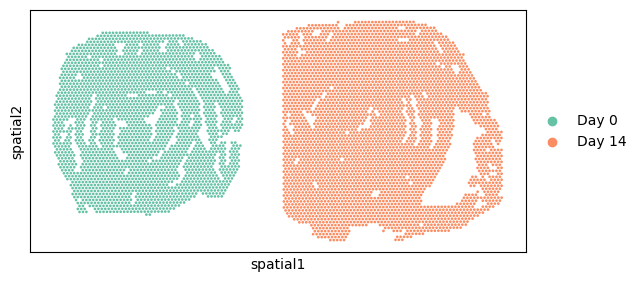

In [14]:
sc.pl.spatial(adata, color="cond", title='', spot_size=80, palette=palette)

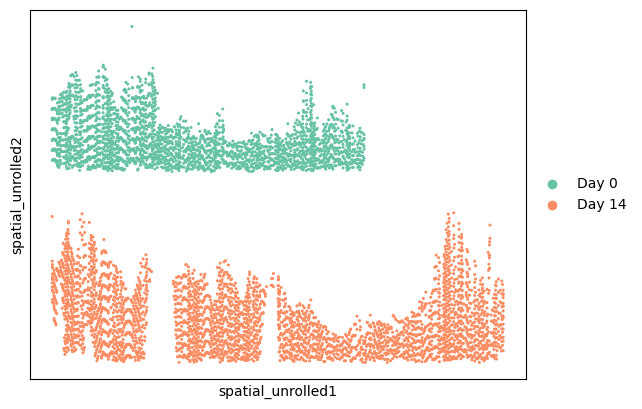

In [15]:
sc.pl.embedding(adata, basis='spatial_unrolled', color="cond", title='', palette=palette)

In [16]:
# d0_adata.write(os.path.join(ADATA_PATH, 'Visium_colon_d0_adata.h5ad'))
# d14_adata.write(os.path.join(ADATA_PATH, 'Visium_colon_d14_adata.h5ad'))
# adata.write(os.path.join(ADATA_PATH, 'Visium_colon_adata.h5ad'))

In [17]:
adata

AnnData object with n_obs × n_vars = 6234 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'cond', 'id', 'row', 'col', 'layer', 'ord', 'dist', 'spot', 'pixel_x', 'pixel_y'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'cond_colors'
    obsm: 'spatial', 'spatial_unrolled'
    layers: 'counts', 'normalized', 'log_norm'

In [18]:
adata = adata[~np.isnan(adata.obsm['spatial_unrolled']).any(axis=1)].copy()

In [19]:
nbrs = NearestNeighbors(
    n_neighbors=5,
    algorithm='ball_tree').fit(adata.obsm['spatial_unrolled'])
dist, ind = nbrs.kneighbors()

In [20]:
thr = np.percentile(dist[:,4], 99.9)

In [21]:
adata = adata[~(dist[:,4] > thr)].copy()

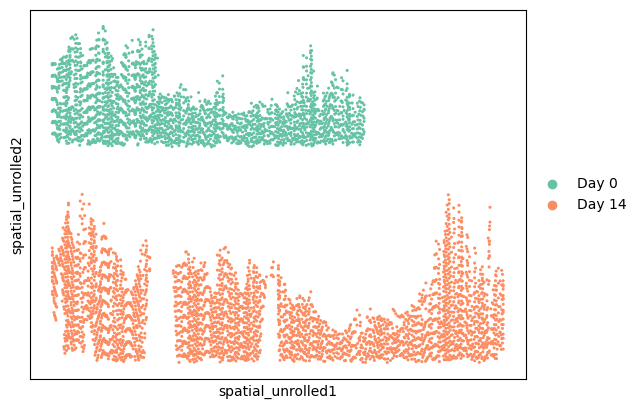

In [22]:
sc.pl.embedding(adata, basis='spatial_unrolled', color="cond", title='', palette=palette)

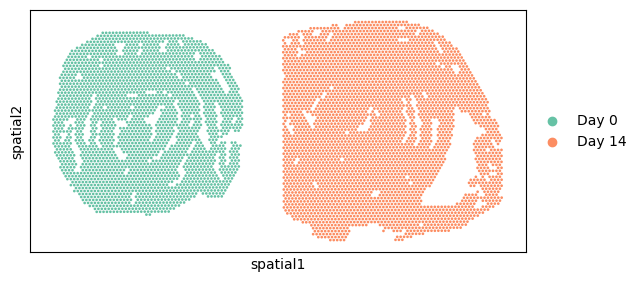

In [23]:
sc.pl.spatial(adata, color="cond", title='', spot_size=80, palette=palette)

In [24]:
adata

AnnData object with n_obs × n_vars = 6168 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'cond', 'id', 'row', 'col', 'layer', 'ord', 'dist', 'spot', 'pixel_x', 'pixel_y'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'cond_colors'
    obsm: 'spatial', 'spatial_unrolled'
    layers: 'counts', 'normalized', 'log_norm'

In [25]:
# adata.write(os.path.join(ADATA_PATH, 'Visium_colon_unrolled_adata.h5ad'))